In [20]:
import pickle
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
%matplotlib inline


## Exploratory Data Analysis and Building a model for relationship between greenhouse gas emissions from a car and that car's features

We've collected the data, cleaned it up -- now let's build a model!

### Step 1: Prepare dataframe for developing linear regression model
*Edit and add features as needed for desired model*

-

Open the `all_cars_eda` pickled dataframe with all cars data

In [21]:
with open('pickles/all_cars_eda.pickle','rb') as read_file:
    all_cars_eda = pickle.load(read_file)

-

Create binned categories for `years` to then create dummy columns for. >>

In [22]:
all_cars_eda['year_range'] = ['1984-1999' if year in [1984, 1985, 1986, 
                                                      1987, 1988, 1989, 
                                                      1990, 1991, 1992, 
                                                      1993, 1994, 1995, 
                                                      1996, 1997, 1998, 
                                                      1999] 
                              else '2000-2010' if year in [2000,2001,
                                                           2002,2003,
                                                           2004,2005,
                                                           2006,2007,
                                                           2008,2009,
                                                           2010]
                              else '2011-2021' if year in [2011,2012,
                                                           2013,2014,
                                                           2015,2016,
                                                           2017,2018,
                                                           2019,2020,
                                                           2021]
                              else np.nan for year in all_cars_eda['year']]

-

**REMOVING FEATURES**

**Removing miles-per-gallon - `mpg`.**  By removing we'll allow opportunity to examine any relationships between the other features of the car and the greenhouse gas emissions, otherwise miles-per-gallon would be too dominant of feature and also isn't really telling us more deeply what causes greenhouse gas emissions from the mechanics of how the car was built

**Removing `make`, `model`, & `trans_speed`.**  Can say with confidence these are not signiciantly relevant to the greenhouse gas emissions of the car and would not be worth create dummies for the non-numberic categories.

**Removing `year`.**  Will just use the dummy columns created for years.

In [23]:
del all_cars_eda['mpg']
del all_cars_eda['make']
del all_cars_eda['model']
del all_cars_eda['trans_speed']
del all_cars_eda['year']

Verify everything looks okay >>

In [24]:
all_cars_eda.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5260 entries, 0 to 5264
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   capacity_liters  5260 non-null   float64
 1   cylinders        5260 non-null   int32  
 2   transmission     5260 non-null   object 
 3   fuel_type        5260 non-null   object 
 4   gg_emissions     5260 non-null   float64
 5   year_range       5260 non-null   object 
dtypes: float64(2), int32(1), object(3)
memory usage: 267.1+ KB


-

Create the dummies for the features that are objects >>

In [25]:
all_cars_eda = pd.get_dummies(all_cars_eda)

In [26]:
all_cars_eda.rename(columns = {'fuel_type_Premium Gasoline': 'fuel_premium',
                               'fuel_type_Regular Gasoline': 'fuel_regular',
                               'year_range_1984-1999': 'years_1984_1999',
                               'year_range_2000-2010': 'years_2000_2010',
                               'year_range_2011-2021': 'years_2011_2021'
                              },
                    inplace = True)

### Step 2: Exploratory Data Analysis

#### CORRELATION

Examine the correlations of all the values>>

In [27]:
all_cars_eda.corr()

,capacity_liters,cylinders,gg_emissions,transmission_Automatic,transmission_Manual,fuel_type_Diesel,fuel_premium,fuel_regular,years_1984_1999,years_2000_2010,years_2011_2021
capacity_liters,1.000000,0.906330,0.773934,0.264746,-0.264746,0.126013,0.135443,-0.199060,-0.002876,0.165670,-0.135392
cylinders,0.906330,1.000000,0.740521,0.309784,-0.309784,0.064916,0.253522,-0.276253,-0.061969,0.187582,-0.091598
gg_emissions,0.773934,0.740521,1.000000,0.169507,-0.169507,-0.010432,0.117899,-0.105576,0.187924,0.170069,-0.339577
transmission_Automatic,0.264746,0.309784,0.169507,1.000000,-1.000000,-0.058951,0.196403,-0.152445,-0.378349,0.032117,0.370772
transmission_Manual,-0.264746,-0.309784,-0.169507,-1.000000,1.000000,0.058951,-0.196403,0.152445,0.378349,-0.032117,-0.370772
fuel_type_Diesel,0.126013,0.064916,-0.010432,-0.058951,0.058951,1.000000,-0.198311,-0.376113,0.126626,-0.098428,-0.050836
fuel_premium,0.135443,0.253522,0.117899,0.196403,-0.196403,-0.198311,1.000000,-0.833584,-0.350920,0.129585,0.260515
fuel_regular,-0.199060,-0.276253,-0.105576,-0.152445,0.152445,-0.376113,-0.833584,1.000000,0.260377,-0.067030,-0.217627
years_1984_1999,-0.002876,-0.061969,0.187924,-0.378349,0.378349,0.126626,-0.350920,0.260377,1.000000,-0.456951,-0.669124
years_2000_2010,0.165670,0.187582,0.170069,0.032117,-0.032117,-0.098428,0.129585,-0.067030,-0.456951,1.000000,-0.355271


-

Now narrow in on just the greenhouse gas emissions column (the 'y') to examine the value of greatest interest more easily >>

In [28]:
(all_cars_eda.corr()).iloc[:,2]

capacity_liters           0.773934
cylinders                 0.740521
gg_emissions              1.000000
transmission_Automatic    0.169507
transmission_Manual      -0.169507
fuel_type_Diesel         -0.010432
fuel_premium              0.117899
fuel_regular             -0.105576
years_1984_1999           0.187924
years_2000_2010           0.170069
years_2011_2021          -0.339577
Name: gg_emissions, dtype: float64

-

Now create a heatmap to help look at the relationships of the values >>

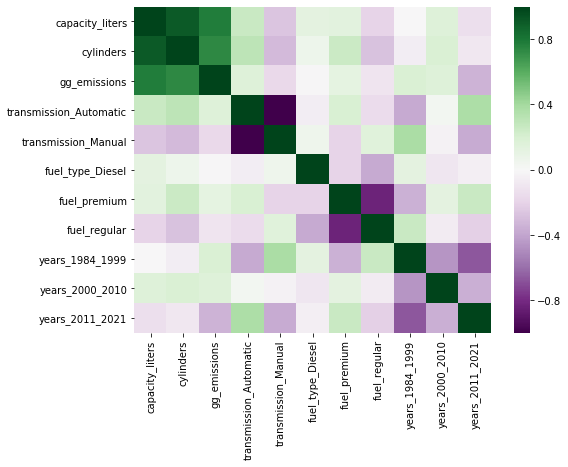

In [29]:
plt.figure(figsize=(8,6))
ax = sns.heatmap(all_cars_eda.corr(), cmap="PRGn")
ax.set_ylim(11.0, 0);

And now a Greenhouse Gas Emissions correlation matrix

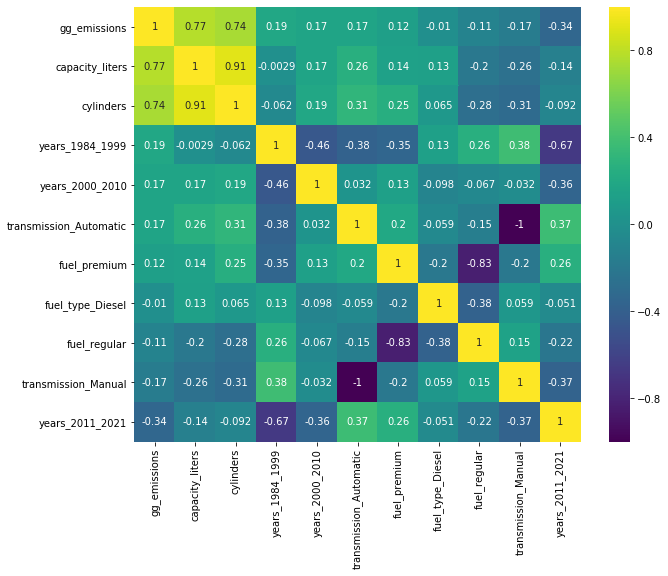

In [30]:
k = 11
cols = all_cars_eda.corr().nlargest(k, 'gg_emissions')['gg_emissions'].index
cm = all_cars_eda[cols].corr()
plt.figure(figsize=(10,8))
ax = sns.heatmap(cm, annot=True, cmap = 'viridis')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5);

Create a pair plot for a deeper look at relationship between all features and variable >>

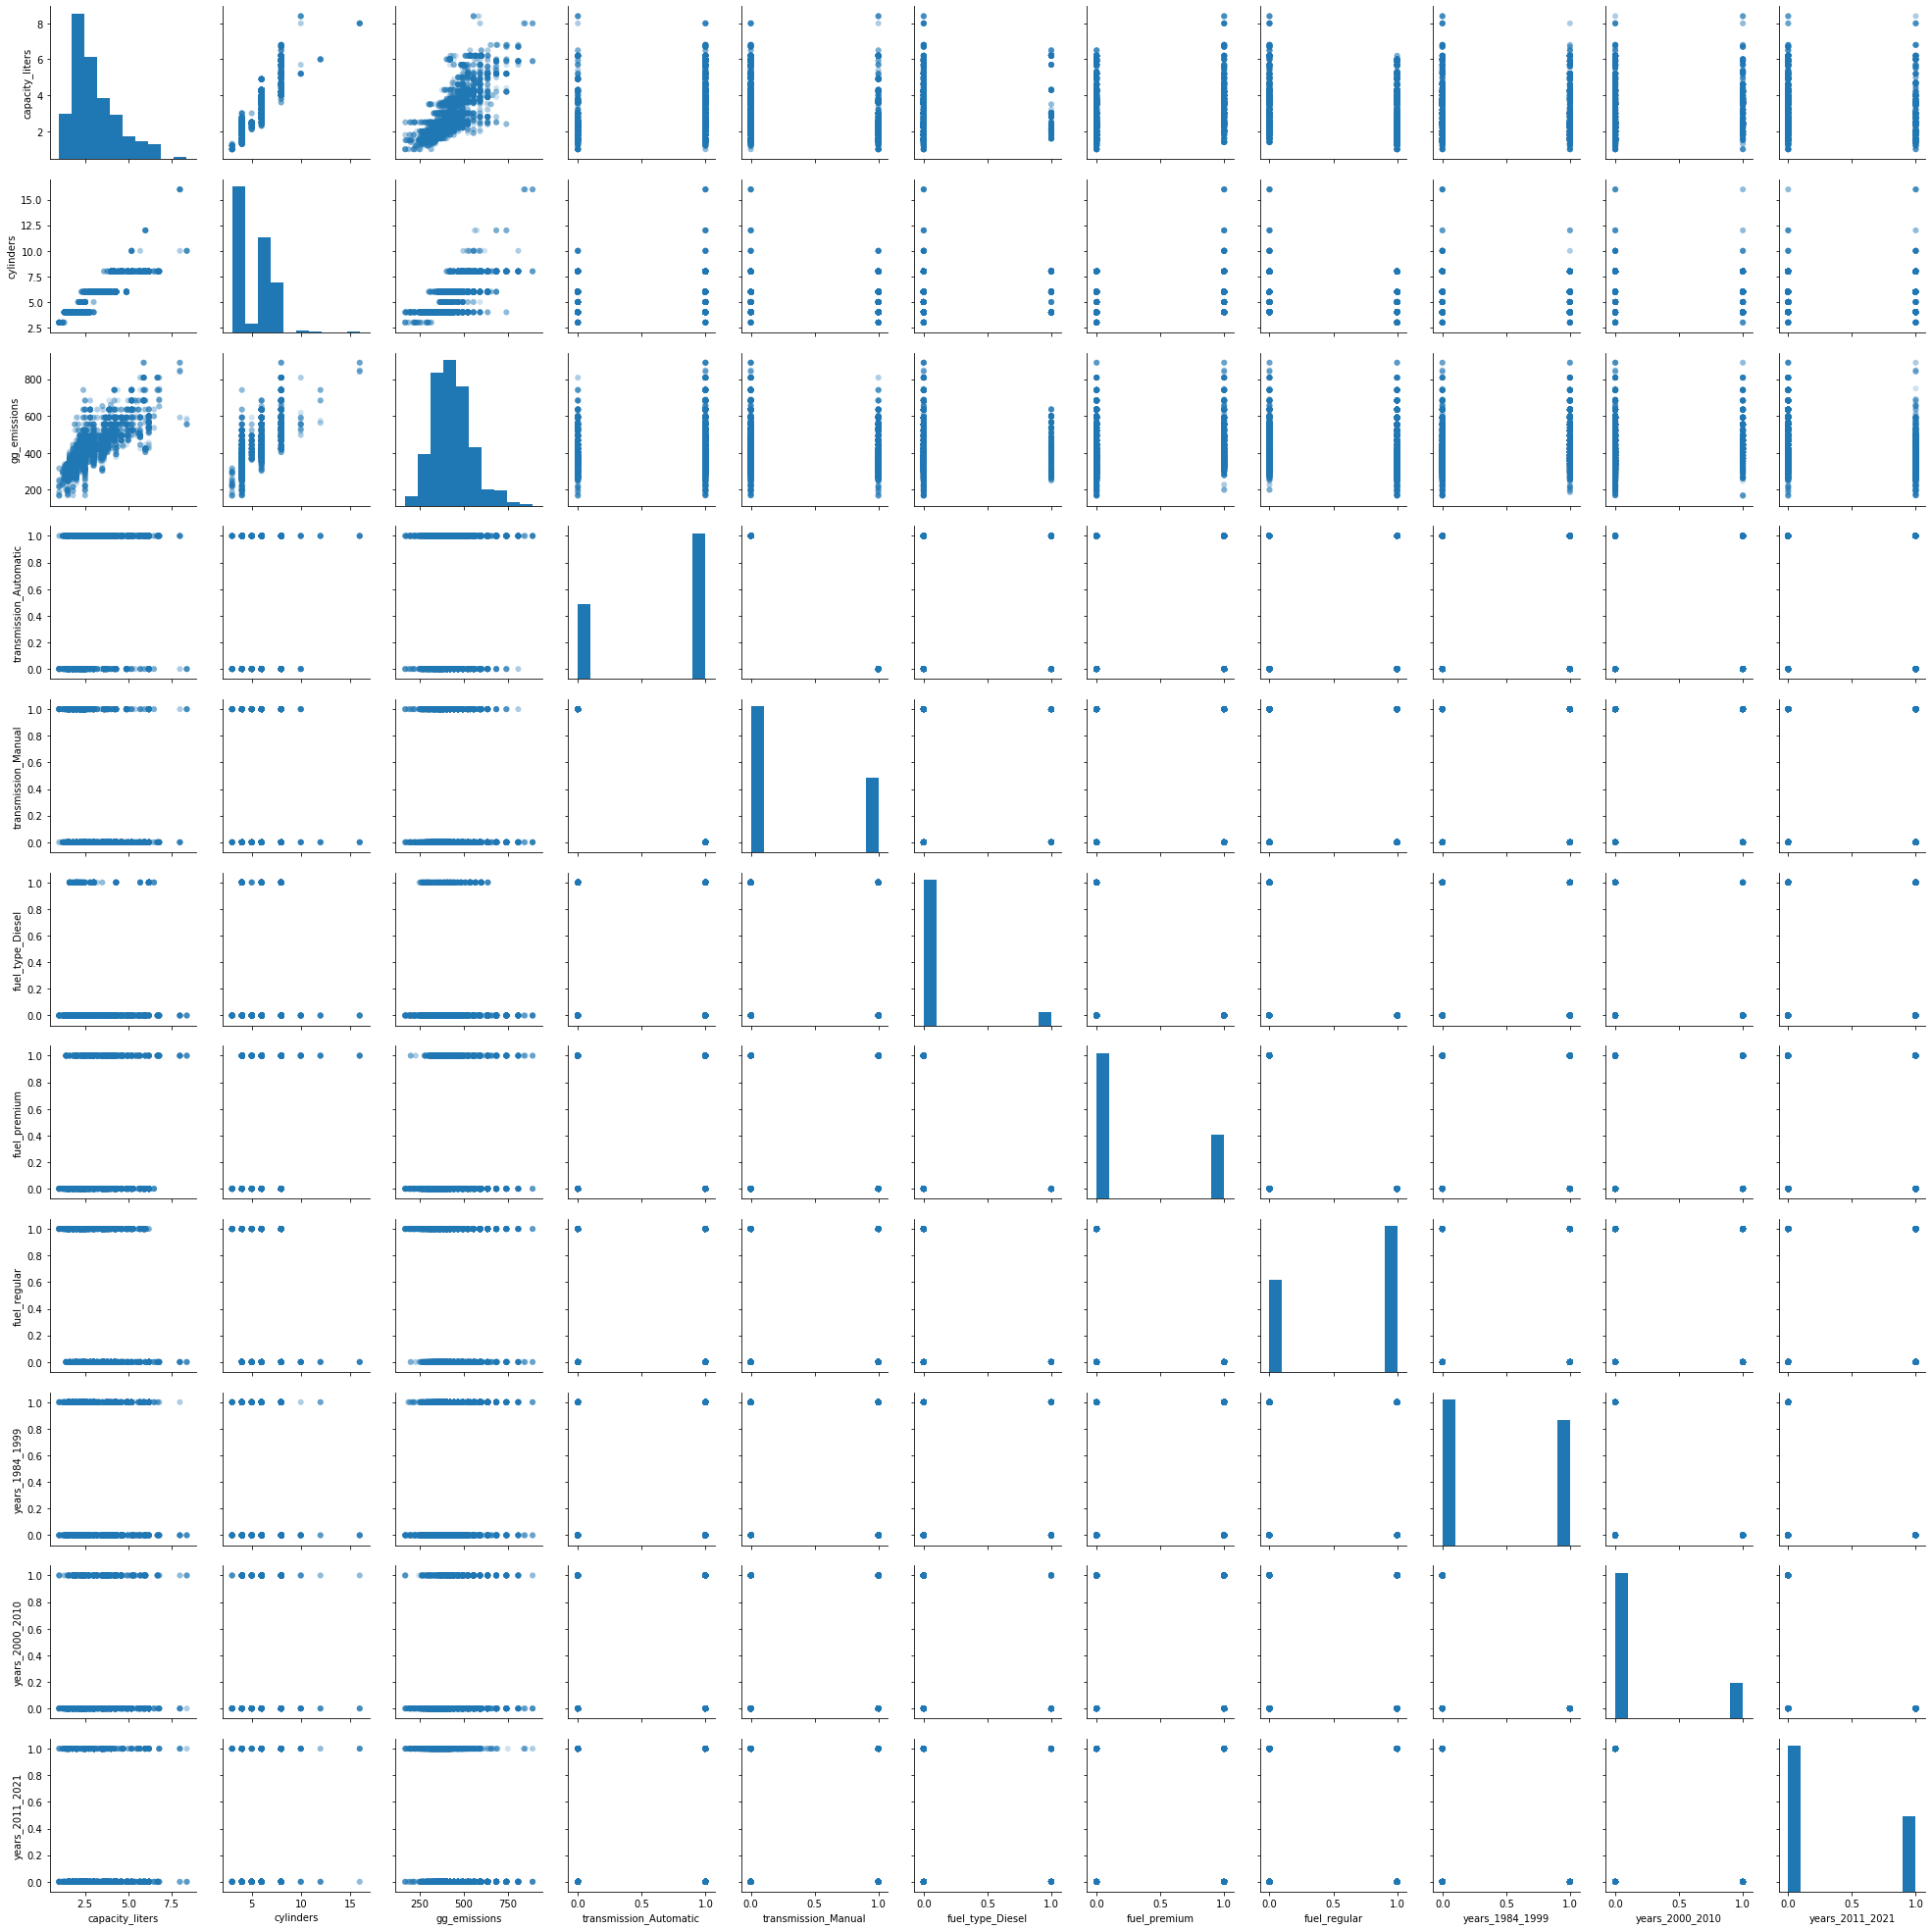

In [31]:
sns.pairplot(all_cars_eda, plot_kws=dict(alpha=.2, edgecolor='none'));

#### OUTLIERS EXAMINATION

For our non-dummied features, we'll look at their outliers (dummies can be ignored) >>

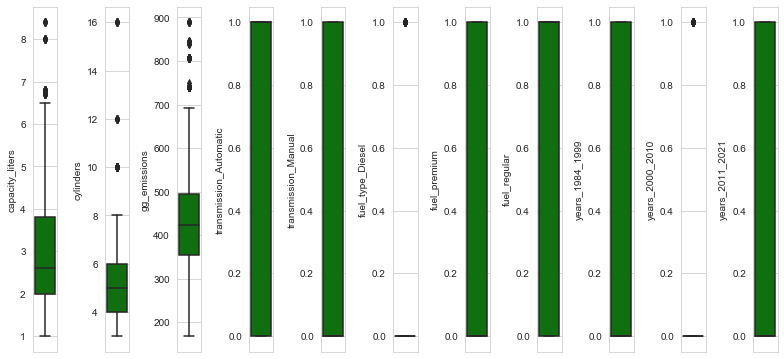

In [39]:
l = all_cars_eda.columns.values
number_of_columns=11
number_of_rows = len(l)-1/number_of_columns
plt.figure(figsize=(number_of_columns,5*number_of_rows))
for i in range(0,len(l)):
    plt.subplot(number_of_rows + 1,number_of_columns,i+1)
    sns.set_style('whitegrid')
    sns.boxplot(all_cars_eda[l[i]],color='green',orient='v')
    plt.tight_layout()

#### CHECK DISTRIBUTION SKEWNESS

Again for our non-dummied features, we'll look at their skewness (dummies can be ignored) >>

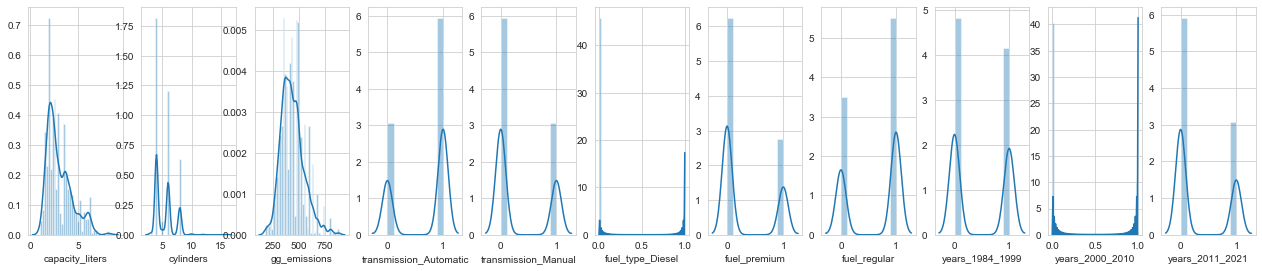

In [40]:
plt.figure(figsize=(2*number_of_columns,5*number_of_rows))
for i in range(0,len(l)):
    plt.subplot(number_of_rows + 1,number_of_columns,i+1)
    sns.distplot(all_cars_eda[l[i]],kde=True)

### STEP 3: BUILD THE MODEL

In [42]:
# Define the model for greenhouse gas emissions of cars
cars_model = smf.ols('''gg_emissions ~ capacity_liters + cylinders 
              + transmission_Automatic + transmission_Manual
              + fuel_type_Diesel + fuel_premium + fuel_regular 
              + years_1984_1999 + years_2000_2010 + years_2011_2021''',
                     data=all_cars_eda)

# Fit the model
cars_fit = cars_model.fit()

# Print summary statistics of the model's performance
cars_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           gg_emissions   R-squared:                       0.689
Model:                            OLS   Adj. R-squared:                  0.688
Method:                 Least Squares   F-statistic:                     1659.
Date:                Sun, 12 Jul 2020   Prob (F-statistic):               0.00
Time:                        17:30:33   Log-Likelihood:                -29196.
No. Observations:                5260   AIC:                         5.841e+04
Df Residuals:                    5252   BIC:                         5.846e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 93.4627      1.751     53.365      0.000      90.029      96.896
capacity_liters           46.6975      1.597     29.238      0.000      43.566      49.829
cylinders                 13.6723      1.332     10.266      0.000      11.061      16.283
transmission_Automatic    54.7352      1.510     36.258      0.000      51.776      57.695
transmission_Manual       38.7274      1.235     31.370      0.000      36.307      41.148
fuel_type_Diesel          -1.4318      2.348     -0.610      0.542      -6.034       3.171
fuel_premium              54.1569      1.787     30.306      0.000      50.654      57.660
fuel_regular              40.7376      1.283     31.753      0.000      38.222      43.253
years_1984_1999           65.4182      1.426     45.866      0.000      62.622      68.214
years_2000_2010           39.0141      1.727     22.592      0.000      35.629      42.400
years_2011_2021          -10.9697      1.395     -7.863      0.000     -13.705      -8.235
==============================================================================
Omnibus:                      363.270   Durbin-Watson:                   0.342
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              778.392
Skew:                           0.455   Prob(JB):                    9.42e-170
Kurtosis:                       4.650   Cond. No.                     7.68e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.98e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

-

#### PLOT THE RESIDUALS VS FITTED VALUES

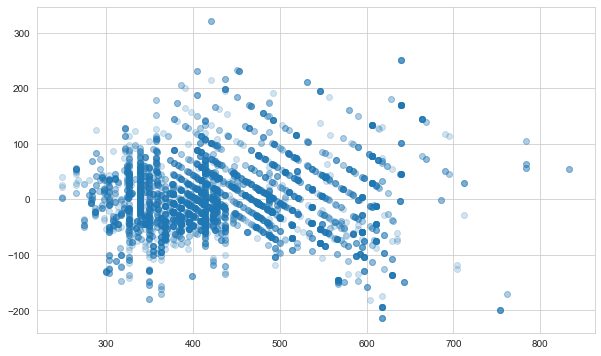

In [50]:
plt.figure(figsize=(10,6))
plt.scatter(cars_fit.predict(), cars_fit.resid, alpha=0.2);

#### USE SKLEARN TO GET MODEL STATS - SHOULD MATCH ABOVE

*Only used as test to verify different method to get values works*

In [59]:
# Create an empty model
cars_lr = LinearRegression()

# Choose the predictor variables, here all but the first which is the response variable
X = all_cars_eda.loc[:, ['capacity_liters', 'cylinders', 'transmission_Automatic', 
                         'transmission_Manual', 'fuel_type_Diesel','fuel_premium',
                         'fuel_regular','years_1984_1999','years_2000_2010',
                         'years_2011_2021'
                        ]]

# Identify the response variable
y = all_cars_eda.loc[:, ['gg_emissions']]

# Fit the model to the full dataset
cars_lr.fit(X, y)

# Print out the R^2 for the model against the full dataset
print(f'R^2: {cars_lr.score(X,y)}')
print('\n')
print(f'Intercept: {cars_lr.intercept_}')
print('\n')
print(f'Coefficients: {cars_lr.coef_}')

R^2: 0.6886023345695953


Intercept: [202.5024378]


Coefficients: [[ 46.69746523  13.67227487   8.00388736  -8.00388736 -32.58602505
   23.00268089   9.58334416  34.26399156   7.85988579 -42.12387734]]
